In [ ]:
# 1. Imports and Configuration
!pip install tensorflow --quiet
import os
import pandas as pd
import numpy as np
import requests,time
from datetime import datetime, timezone, timedelta
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import sys
import warnings
import gradio as gr

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

INPUT_STEPS = 8
RESAMPLE_RULE = '15T'
MIN_TRAINING_SAMPLES = 15
CSV_FILE = 'carpark_multi_snapshots_class.csv'
MODEL_DIR = 'best_lstm_classifiers'
EPOCHS = 30
BATCH_SIZE = 32

# 2. API Config
USERNAME = "solobalama"
PASSWORD = "coder#346"
STATIC_URL = "https://www.netraveldata.co.uk/api/v2/carpark/static"
DYNAMIC_URL = "https://www.netraveldata.co.uk/api/v2/carpark/dynamic"
HEADERS = {"User-Agent": "parking-ml-demo/lstm-classifier-v1"}

STATE_MAPPING = {
    'SPACES': 0, 'OPEN': 0, 'ALMOST FULL': 1, 'FULL': 2, 'CLOSED': 3,
    'UNKNOWN': 4, 'FAULTY': 5
}
STATE_DECODER = {v: k for v, k in STATE_MAPPING.items()}
STATE_ENCODER = LabelEncoder()
STATE_ENCODER.fit(list(STATE_MAPPING.keys()))

LabelEncoder()

In [ ]:
# 3. Data Fetching and Preparation Functions
def get_records(data):
    if isinstance(data, list):
        return data
    elif isinstance(data, dict):
        for k in ('assets', 'data', 'carparks', 'items'):
            if k in data and isinstance(data[k], list):
                return data[k]
    return []

def fetch_static(username, password):
    try:
        r = requests.get(STATIC_URL, auth=(username, password), headers=HEADERS, timeout=20)
        r.raise_for_status()
        records = get_records(r.json())
        rows = []
        for a in records:
            try:
                scode = a.get('systemCodeNumber') or a.get('systemCode')
                defs = a.get('definitions') or a
                if isinstance(defs, list) and defs:
                    defs = defs[0]
                short = defs.get('shortDescription') if isinstance(defs, dict) else None
                conf = a.get('configurations') or a.get('configuration')
                capacity = None
                if isinstance(conf, list) and conf:
                    capacity = conf[0].get('capacity') or conf[0].get('carParkCapacity')
                elif isinstance(conf, dict):
                    capacity = conf.get('capacity') or conf.get('carParkCapacity')
                rows.append({
                    'systemCodeNumber': scode,
                    'shortDescription': short,
                    'capacity': capacity
                })
            except:
                continue
        return pd.DataFrame(rows).dropna(subset=['systemCodeNumber']).drop_duplicates('systemCodeNumber')
    except Exception as e:
        print(f"Error fetching static data: {e}", file=sys.stderr)
        return pd.DataFrame()

def fetch_dynamic(username, password):
    try:
        r = requests.get(DYNAMIC_URL, auth=(username, password), headers=HEADERS, timeout=20)
        r.raise_for_status()
        records = get_records(r.json())
        rows = []
        for a in records:
            try:
                scode = a.get('systemCodeNumber') or a.get('systemCode')
                dyn = a.get('dynamics') or a
                if isinstance(dyn, list) and dyn:
                    dyn = dyn[0]
                occ = dyn.get('occupancy') if isinstance(dyn, dict) else None
                state = dyn.get('occupancyStateDescription') or dyn.get('stateDescription')
                rows.append({
                    'systemCodeNumber': scode,
                    'occupancy': occ,
                    'stateDescription': state
                })
            except:
                continue
        return pd.DataFrame(rows).dropna(subset=['systemCodeNumber'])
    except Exception as e:
        print(f"Error fetching dynamic data: {e}", file=sys.stderr)
        return pd.DataFrame()

def fetch_and_save(username, password, out_csv=CSV_FILE):
    ds = fetch_static(username, password)
    dd = fetch_dynamic(username, password)

    merged = pd.merge(ds, dd, on='systemCodeNumber', how='left')
    merged['fetched_at'] = pd.to_datetime(datetime.now(timezone.utc))

    merged['occupancy'] = pd.to_numeric(merged['occupancy'], errors='coerce')
    merged['capacity'] = pd.to_numeric(merged['capacity'], errors='coerce')

    merged['availableSpaces'] = merged['capacity'] - merged['occupancy']
    merged['availableSpaces'] = merged['availableSpaces'].clip(lower=0)

    merged['state_encoded'] = merged['stateDescription'].str.upper().map(
        STATE_MAPPING
    ).fillna(STATE_MAPPING['UNKNOWN'])

    merged_for_save = merged[[
        'systemCodeNumber', 'shortDescription', 'capacity',
        'availableSpaces', 'state_encoded', 'fetched_at'
    ]].dropna(subset=['capacity', 'state_encoded'])

    file_exists = os.path.exists(out_csv)
    merged_for_save.to_csv(out_csv, mode='a', header=(not file_exists), index=False)

    return merged_for_save.drop_duplicates(subset=['systemCodeNumber'], keep='last')


def build_timeseries(csv_path=CSV_FILE):
    df_snap = pd.read_csv(csv_path, parse_dates=['fetched_at'])
    parks_data = {}

    for pid, grp in df_snap.groupby('systemCodeNumber'):
        latest_info = grp.drop_duplicates(
            subset=['systemCodeNumber'], keep='last'
        ).iloc[0]
        cap = float(latest_info['capacity'])
        name = latest_info['shortDescription']

        state_series = grp.set_index('fetched_at')['state_encoded'].resample(
            RESAMPLE_RULE
        ).last().ffill().bfill().astype(int)

        parks_data[pid] = {
            'class_series': state_series,
            'capacity': cap,
            'name': name
        }
    return parks_data

# 4. LSTM Training
def preprocess_and_window(series, input_steps=INPUT_STEPS, output_steps=1):
    s = series.copy().resample(RESAMPLE_RULE).last().ffill().bfill()
    X, y = [], []
    arr = s.values

    if len(arr) < input_steps + output_steps:
        return np.array([]), np.array([])

    for i in range(len(arr) - input_steps - output_steps + 1):
        X.append(arr[i:i + input_steps])
        y.append(arr[i + input_steps:i + input_steps + output_steps])

    X_final = np.array(X).reshape(len(X), input_steps, 1)
    y_final = np.array(y).reshape(len(y), output_steps)
    return X_final, y_final

def create_lstm_classifier_model(num_classes):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(INPUT_STEPS, 1)),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def train_lstm_classifier(series, pid):
    num_classes = len(STATE_MAPPING)
    X, y = preprocess_and_window(series, input_steps=INPUT_STEPS)

    if len(X) < MIN_TRAINING_SAMPLES:
        print(f"{pid}: Insufficient samples ({len(X)}).")
        return None

    X_tr, X_val, y_tr, y_val = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    model = create_lstm_classifier_model(num_classes)
    model.fit(
        X_tr, y_tr, epochs=EPOCHS, batch_size=BATCH_SIZE,
        verbose=0, validation_data=(X_val, y_val)
    )
    return model



def start_snapshot_collector(username, password, interval_sec=900):
    """
    Continuously fetch parking snapshots every `interval_sec` seconds
    and append them to the CSV file.
    """

    print(f"Starting snapshot collector (interval = {interval_sec} seconds)...")
    print("Press CTRL + C to stop.\n")

    while True:
        try:
            print(f"[{datetime.now(timezone.utc)}] Fetching snapshot...")
            df_new = fetch_and_save(username, password)

            print(f"Saved {len(df_new)} records to CSV.")
            print("-" * 40)

        except Exception as e:
            print(f"ERROR during snapshot fetch: {e}")

        # wait for next iteration
        time.sleep(interval_sec)

import threading
import time
from datetime import datetime, timezone

latest_df = None   # global store for last snapshot


def snapshot_worker(username, password, interval_sec=900):
    global latest_df

    print(f"Snapshot thread started (interval = {interval_sec}s)")
    print("Press CTRL+C to stop.\n")

    while True:
        try:
            print(f"[{datetime.now(timezone.utc)}] Fetching snapshot...")
            latest_df = fetch_and_save(username, password)
            print(f"Saved {len(latest_df)} rows.")
            print("-" * 40)

        except Exception as e:
            print(f"ERROR: {e}")

        time.sleep(interval_sec)



def start_snapshot_collector(username, password, interval_sec=900):
    thread = threading.Thread(
        target=snapshot_worker,
        args=(username, password, interval_sec),
        daemon=True  # stops automatically when main program exits
    )
    thread.start()
    return thread



In [ ]:
import time

In [ ]:
start_snapshot_collector(USERNAME, PASSWORD, interval_sec=120)

time.sleep(5)     # wait for first fetch

df = latest_df
print(df.head())


Snapshot thread started (interval = 120s)
Press CTRL+C to stop.

[2025-11-28 09:58:33.783381+00:00] Fetching snapshot...
Saved 208 rows.
----------------------------------------
  systemCodeNumber                shortDescription  capacity  availableSpaces  \
0           CP0005  Sandyford Square (Civic Cente)      71.0             71.0   
1           CP0007                  College Street      73.0             73.0   
2           CP0010                   Morden Street     105.0            105.0   
3           CP0016                   Saville Place      42.0             42.0   
4           CP0017                    Oxford Multi     139.0            139.0   

   state_encoded                       fetched_at  
0              0 2025-11-28 09:58:34.979118+00:00  
1              0 2025-11-28 09:58:34.979118+00:00  
2              0 2025-11-28 09:58:34.979118+00:00  
3              0 2025-11-28 09:58:34.979118+00:00  
4              0 2025-11-28 09:58:34.979118+00:00  


In [ ]:
df

,systemCodeNumber,shortDescription,capacity,availableSpaces,state_encoded,fetched_at
0,CP0005,Sandyford Square (Civic Cente),71.0,71.0,0,2025-11-28 09:58:34.979118+00:00
1,CP0007,College Street,73.0,73.0,0,2025-11-28 09:58:34.979118+00:00
2,CP0010,Morden Street,105.0,105.0,0,2025-11-28 09:58:34.979118+00:00
3,CP0016,Saville Place,42.0,42.0,0,2025-11-28 09:58:34.979118+00:00
4,CP0017,Oxford Multi,139.0,139.0,0,2025-11-28 09:58:34.979118+00:00
...,...,...,...,...,...,...
204,SSCP18,Harbour Drive,120.0,120.0,0,2025-11-28 09:58:34.979118+00:00
205,SSCP19,Harbour Drive North,20.0,20.0,0,2025-11-28 09:58:34.979118+00:00
206,SSCP20,Saville Street Euro Carpark,86.0,86.0,0,2025-11-28 09:58:34.979118+00:00
207,VMSLCP002,Heworth Interchange (Long Stay),393.0,222.0,0,2025-11-28 09:58:34.979118+00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# BASIC INFO

print("SHAPE:", df.shape)
print("\nINFO:")
print(df.info())
print("\nMISSING VALUES:\n", df.isnull().sum())
print("\nDESCRIPTIVE STATS:\n", df.describe())


SHAPE: (208, 8)

INFO:
<class 'pandas.core.frame.DataFrame'>
Index: 208 entries, 0 to 208
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   systemCodeNumber  208 non-null    object             
 1   shortDescription  208 non-null    object             
 2   capacity          208 non-null    float64            
 3   availableSpaces   208 non-null    float64            
 4   state_encoded     208 non-null    int64              
 5   fetched_at        208 non-null    datetime64[ns, UTC]
 6   occupancy_pct     208 non-null    float64            
 7   free_pct          208 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(2)
memory usage: 14.6+ KB
None

MISSING VALUES:
 systemCodeNumber    0
shortDescription    0
capacity            0
availableSpaces     0
state_encoded       0
fetched_at          0
occupancy_pct       0
free_pct            0
dt

In [ ]:
df["occupancy_pct"] = (df["capacity"] - df["availableSpaces"]) / df["capacity"] * 100
df["free_pct"] = df["availableSpaces"] / df["capacity"] * 100


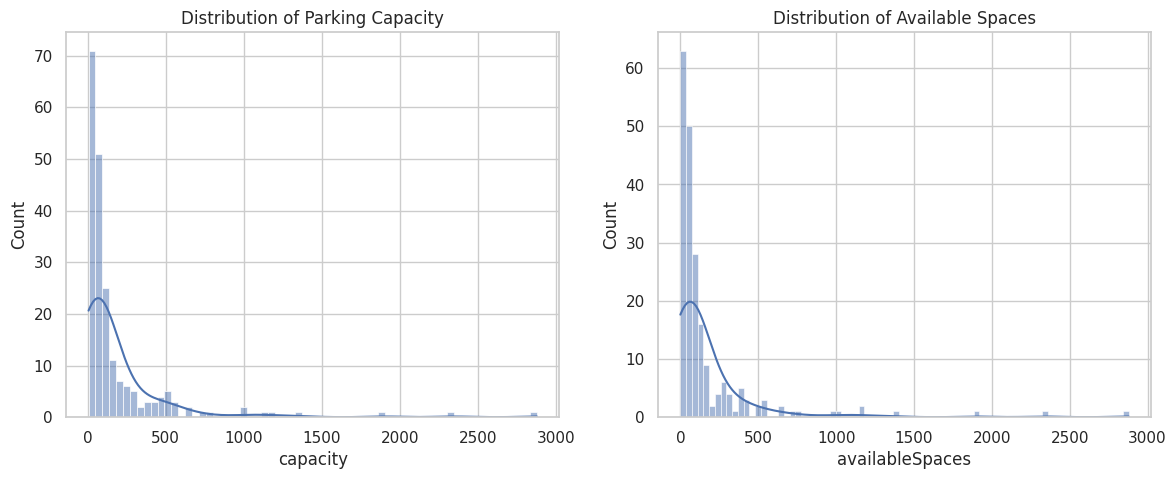

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

sns.histplot(df["capacity"], kde=True, ax=ax[0])
ax[0].set_title("Distribution of Parking Capacity")

sns.histplot(df["availableSpaces"], kde=True, ax=ax[1])
ax[1].set_title("Distribution of Available Spaces")

plt.show()


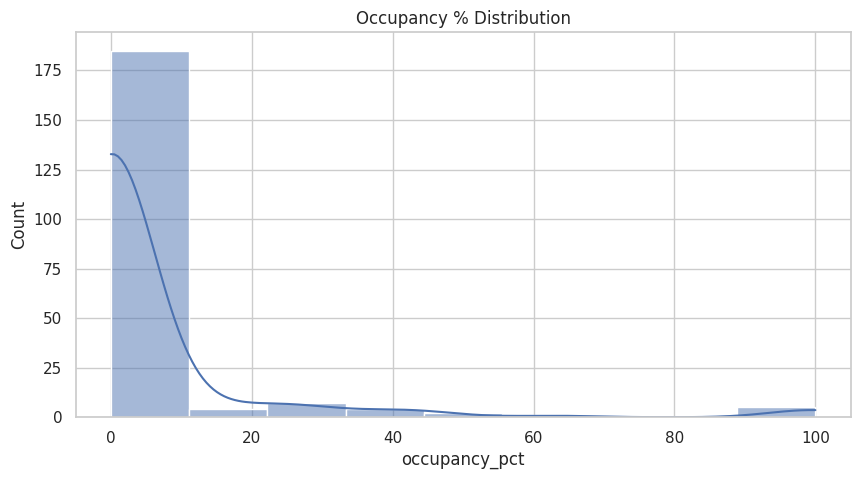

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(df["occupancy_pct"], kde=True)
plt.title("Occupancy % Distribution")
plt.show()


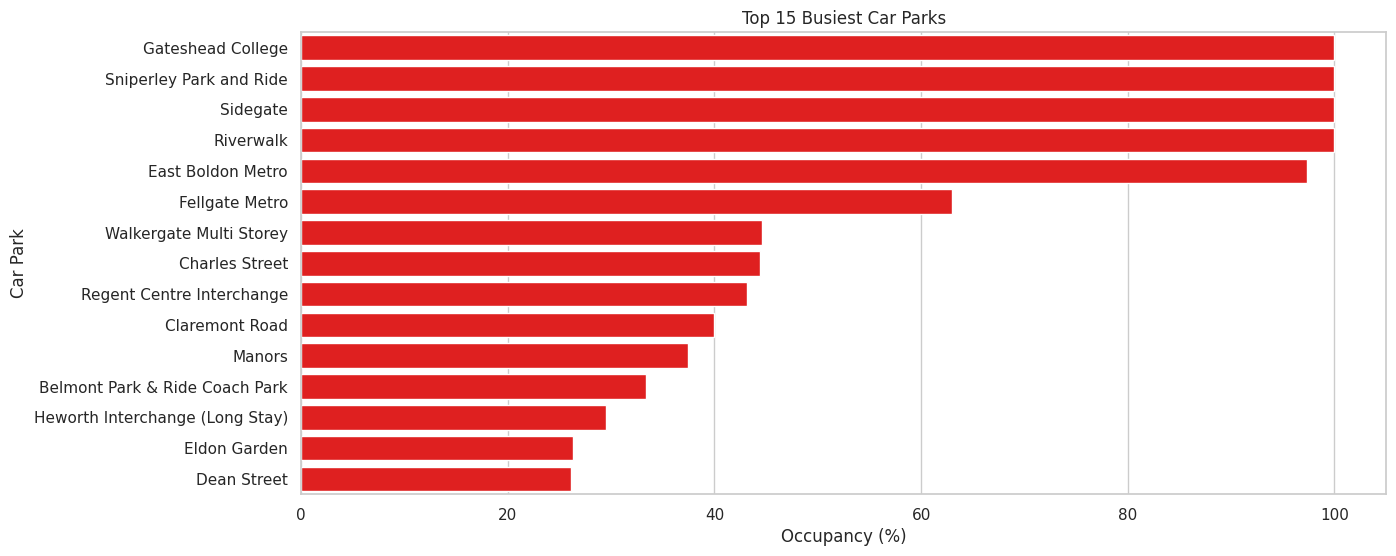

In [ ]:
top_busy = df.sort_values("occupancy_pct", ascending=False).head(15)

plt.figure(figsize=(14,6))
sns.barplot(data=top_busy, x="occupancy_pct", y="shortDescription",color="red")
plt.title("Top 15 Busiest Car Parks")
plt.xlabel("Occupancy (%)")
plt.ylabel("Car Park")
plt.show()


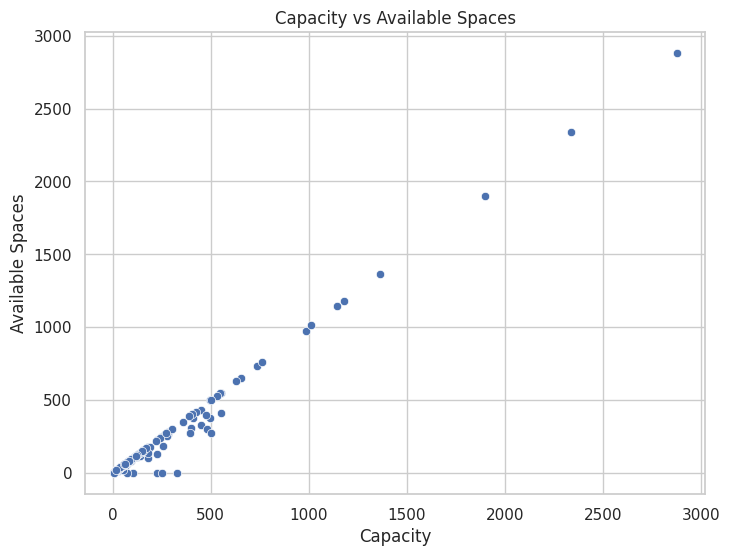

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="capacity", y="availableSpaces")
plt.title("Capacity vs Available Spaces")
plt.xlabel("Capacity")
plt.ylabel("Available Spaces")
plt.show()

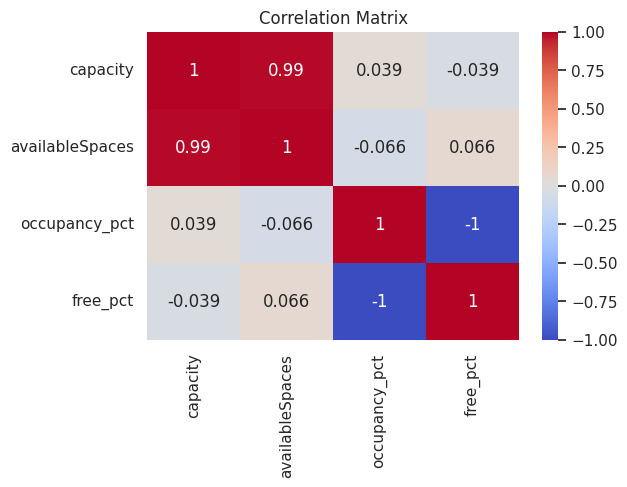

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(df[["capacity", "availableSpaces", "occupancy_pct", "free_pct"]].corr(),
            annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


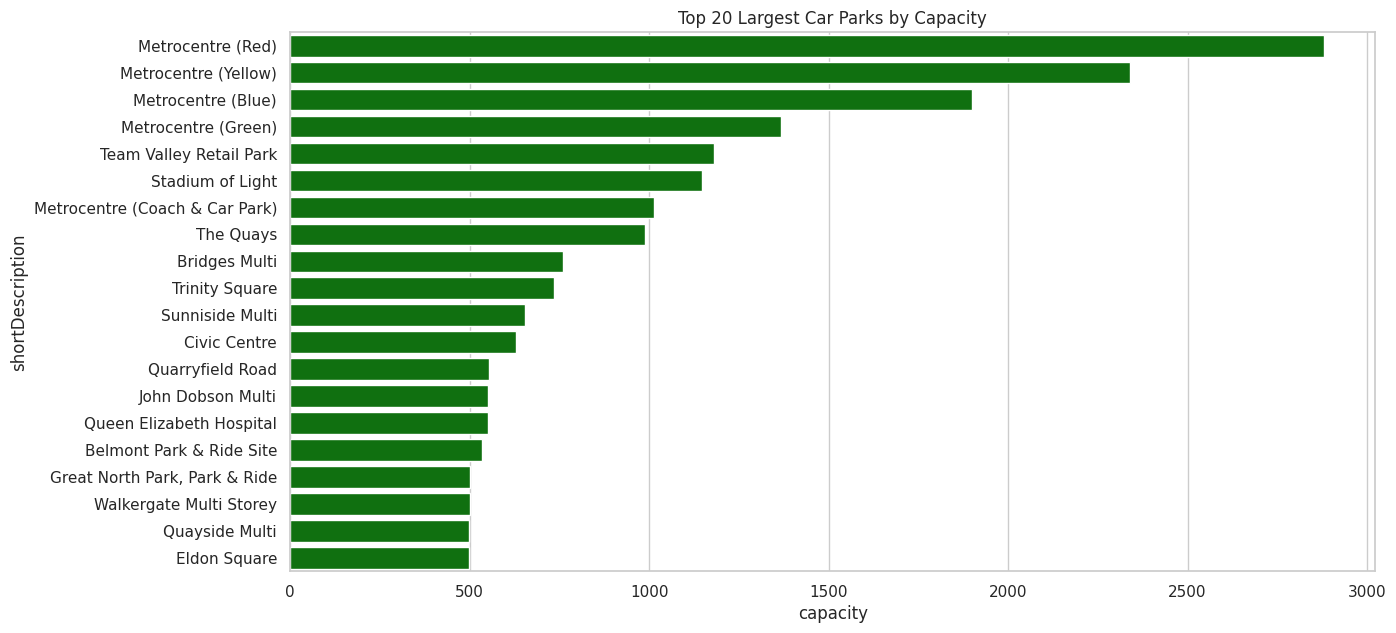

In [ ]:
large_parks = df.sort_values("capacity", ascending=False).head(20)

plt.figure(figsize=(14,7))
sns.barplot(data=large_parks, x="capacity", y="shortDescription",color="green")
plt.title("Top 20 Largest Car Parks by Capacity")
plt.show()


In [ ]:
print(df[["shortDescription", "capacity", "availableSpaces", "occupancy_pct"]]
      .sort_values("occupancy_pct", ascending=False))


                     shortDescription  capacity  availableSpaces  \
56                  Gateshead College     226.0              0.0   
96            Sniperley Park and Ride     326.0              0.0   
102                          Sidegate     104.0              0.0   
103                         Riverwalk     250.0              0.0   
145                 East Boldon Metro      75.0              2.0   
..                                ...       ...              ...   
202                       Pier Parade      60.0             60.0   
204                     Harbour Drive     120.0            120.0   
205               Harbour Drive North      20.0             20.0   
206       Saville Street Euro Carpark      86.0             86.0   
208  Heworth Interchange (Short Stay)      64.0             64.0   

     occupancy_pct  
56      100.000000  
96      100.000000  
102     100.000000  
103     100.000000  
145      97.333333  
..             ...  
202       0.000000  
204       0.000

In [ ]:
print(df.groupby("shortDescription")["occupancy_pct"].mean().sort_values(ascending=False))


shortDescription
Gateshead College                 100.000000
Sidegate                          100.000000
Sniperley Park and Ride           100.000000
Riverwalk                         100.000000
East Boldon Metro                  97.333333
                                     ...    
Westbourne Terrace                  0.000000
Whickham Shopping (Long Stay)       0.000000
Whickham Shopping (Short Stay)      0.000000
Whitley Road                        0.000000
Wreath Quay Road                    0.000000
Name: occupancy_pct, Length: 206, dtype: float64


In [ ]:
parks_data =build_timeseries(CSV_FILE)
parks_data

{'CP0005': {'class_series': fetched_at
  2025-11-28 09:00:00+00:00    0
  Freq: 15min, Name: state_encoded, dtype: int64,
  'capacity': 71.0,
  'name': 'Sandyford Square (Civic Cente)'},
 'CP0007': {'class_series': fetched_at
  2025-11-28 09:00:00+00:00    0
  Freq: 15min, Name: state_encoded, dtype: int64,
  'capacity': 73.0,
  'name': 'College Street'},
 'CP0010': {'class_series': fetched_at
  2025-11-28 09:00:00+00:00    0
  Freq: 15min, Name: state_encoded, dtype: int64,
  'capacity': 105.0,
  'name': 'Morden Street'},
 'CP0016': {'class_series': fetched_at
  2025-11-28 09:00:00+00:00    0
  Freq: 15min, Name: state_encoded, dtype: int64,
  'capacity': 42.0,
  'name': 'Saville Place'},
 'CP0017': {'class_series': fetched_at
  2025-11-28 09:00:00+00:00    0
  Freq: 15min, Name: state_encoded, dtype: int64,
  'capacity': 139.0,
  'name': 'Oxford Multi'},
 'CP0021': {'class_series': fetched_at
  2025-11-28 09:00:00+00:00    0
  Freq: 15min, Name: state_encoded, dtype: int64,
  'capaci

In [ ]:
for pid, pdata in parks_data.items():
    print(pid, type(pdata), pdata.keys())
    break


CP0005 <class 'dict'> dict_keys(['class_series', 'capacity', 'name'])


In [ ]:
parks_data.items()


dict_items([('CP0005', {'class_series': fetched_at
2025-11-28 09:00:00+00:00    0
Freq: 15min, Name: state_encoded, dtype: int64, 'capacity': 71.0, 'name': 'Sandyford Square (Civic Cente)'}), ('CP0007', {'class_series': fetched_at
2025-11-28 09:00:00+00:00    0
Freq: 15min, Name: state_encoded, dtype: int64, 'capacity': 73.0, 'name': 'College Street'}), ('CP0010', {'class_series': fetched_at
2025-11-28 09:00:00+00:00    0
Freq: 15min, Name: state_encoded, dtype: int64, 'capacity': 105.0, 'name': 'Morden Street'}), ('CP0016', {'class_series': fetched_at
2025-11-28 09:00:00+00:00    0
Freq: 15min, Name: state_encoded, dtype: int64, 'capacity': 42.0, 'name': 'Saville Place'}), ('CP0017', {'class_series': fetched_at
2025-11-28 09:00:00+00:00    0
Freq: 15min, Name: state_encoded, dtype: int64, 'capacity': 139.0, 'name': 'Oxford Multi'}), ('CP0021', {'class_series': fetched_at
2025-11-28 09:00:00+00:00    0
Freq: 15min, Name: state_encoded, dtype: int64, 'capacity': 257.0, 'name': 'Dean Str

In [ ]:
df


,systemCodeNumber,shortDescription,capacity,availableSpaces,state_encoded,fetched_at,occupancy_pct,free_pct
0,CP0005,Sandyford Square (Civic Cente),71.0,71.0,0,2025-11-28 09:13:33.784857+00:00,0.000000,100.000000
1,CP0007,College Street,73.0,73.0,0,2025-11-28 09:13:33.784857+00:00,0.000000,100.000000
2,CP0010,Morden Street,105.0,105.0,0,2025-11-28 09:13:33.784857+00:00,0.000000,100.000000
3,CP0016,Saville Place,42.0,42.0,0,2025-11-28 09:13:33.784857+00:00,0.000000,100.000000
4,CP0017,Oxford Multi,139.0,139.0,0,2025-11-28 09:13:33.784857+00:00,0.000000,100.000000
...,...,...,...,...,...,...,...,...
204,SSCP18,Harbour Drive,120.0,120.0,0,2025-11-28 09:13:33.784857+00:00,0.000000,100.000000
205,SSCP19,Harbour Drive North,20.0,20.0,0,2025-11-28 09:13:33.784857+00:00,0.000000,100.000000
206,SSCP20,Saville Street Euro Carpark,86.0,86.0,0,2025-11-28 09:13:33.784857+00:00,0.000000,100.000000
207,VMSLCP002,Heworth Interchange (Long Stay),393.0,277.0,0,2025-11-28 09:13:33.784857+00:00,29.516539,70.483461
